# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle
import numpy as np
import cv2

# TODO: fill this in based on where you saved the training and testing data
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

def normalize_image(image):
    return cv2.normalize(image, None, 0.0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

def bind_image(image, box, src):
    imshape = image.shape[:2]
    src_img = cv2.resize(image, tuple(src))
    x1, y1, x2, y2 = box 
    src_img = src_img[y1:y2, x1:x2,:]
    try:
        dst_img = cv2.resize(src_img, imshape)
    except:
        dst_img = image
    return dst_img

def pre_process(image, box=None, src=None):
    if box is not None and src is not None:
        image = bind_image(image, box, src)
    
    image = normalize_image(image)
    image = cv2.resize(image, (32, 32))
    return image

X_train_src, X_test_src = train['sizes'], test['sizes']
X_train_co, X_test_co = train['coords'], test['coords']

X_train = np.array([pre_process(image, box, src ) for
                    image, box, src in
                    zip(X_train, X_train_co, X_train_src)],
                   dtype=np.float32)
X_test = np.array([pre_process(image, box, src) for 
                   image, box, src in
                   zip(X_test, X_test_co, X_test_src)],
                  dtype=np.float32)


In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train.shape

# TODO: how many classes are in the dataset
n_classes = len(set(train['labels']))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (34799, 32, 32, 3)
Number of classes = 43


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]


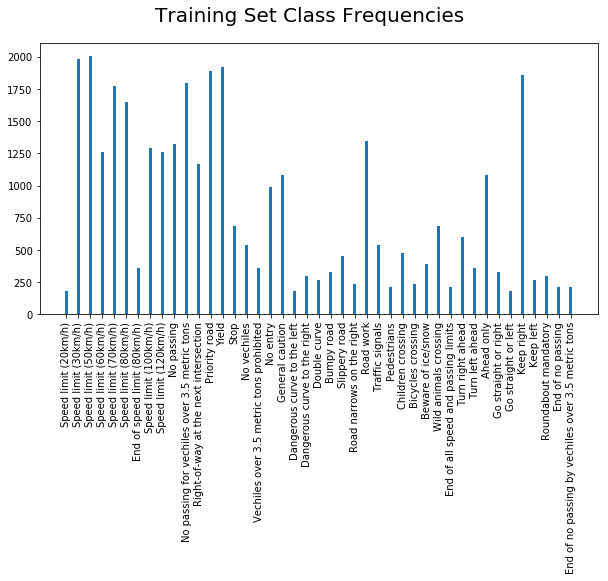

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
import csv
import numpy as np

label_names = {}
with open('signnames.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        label_names[row[0]] = row[1]

labelArray = []
label_classes = []
for i in range(43):
    labelArray.append(label_names[str(i)])
    label_classes.append(i)
# print (labelArray)
label_count = np.zeros((43),int)
# print(label_count)
for label in y_train:
#     print(label)
    label_count[label] += 1
# print (label_count)


# plt.show()
# # plt.plot(labelArray, label_count)
fig, ax = plt.subplots()
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.set_xticklabels(labelArray)
fig.set_size_inches(10,5)
# fig.canvas.draw()
plt.xticks(label_count, labelArray, rotation='vertical')
# plt.hist(label_count,43,alpha=0.5)

fig.suptitle('Training Set Class Frequencies', fontsize=20)
print(label_classes)
plt.bar(label_classes, label_count, align='center', width=0.25)
plt.xticks(label_classes, labelArray, rotation='vertical')


plt.show()

## Above, I create a visualization for how much training data exists for each possible classification. We see that for some classifications, we have significantly fewer samples than others.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
# import cv2


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
#could also do cv2.grayscale right here
# X_train_gray = np.empty((0, 32, 32, 1))

#     print (img.shape)
# image = cv2.cvtColor(X_train[0], cv2.COLOR_RGB2GRAY)
# #     print('test')
# plt.figure()
# plt.imshow(image)
    
print ('woo')




woo


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:** The data is normalized on a scale of 0-1 while retaining its color properties. I normalized the data because during training, the weights of the network are multiplied by each other. If the data values are not kept under or within 1, they can have extremely wide ranges, which makes finding global minimums and maximums during stochastic gradient descent much more costly.

In [5]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:** I set up the training by importing the dataset for training, as well as the testing data for testing. After training the model, the the model is tested against the testing data for accuracy by feeding the testing data into the feed_dict.

I originally tried another DNN architecture (implemented in function `DNN(x)`) based off of another research paper, and included a dropout layer. Unfortunately, I wasn't able to achieve similar results. I decided to go with the LeNet architecture after reading about its original success early on and seeing it suggested in the lessons.

I went with 20 epochs because it seemed that the architecture's accuracy wasn't substantially more accurate after that many, and end results came out to be similar with new images taken from the internet (I attempted 50 epochs as well. Cost dropped to 0 but image prediction performance didn't improve, if not decrease).

I chose a batch size of 128 because I knew that the memory of the G2.2. instance was capable of handling that many images at once.

I chose ReLu because it has a constant gradient and is better for modeling positive real numbers, as well as having more efficient training.

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
from tensorflow.contrib.layers import flatten
batches = 64

inputShape = X_train[0].shape[0] *  X_train[0].shape[1] *  X_train[0].shape[2]
print (inputShape)
def architecture(x):
    WeightConv1 = tf.Variable(tf.truncated_normal(shape=(5,5,3,6)))
    WeightBias1 = tf.Variable(tf.constant(0.0, shape=(6,)))
    conv1 = tf.nn.conv2d(x, WeightConv1, strides=[1,1,1,1], padding='VALID') + WeightBias1
    
    conv1 = tf.nn.relu(conv1)
    
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5,5,6,16)))
    conv2_b = tf.Variable(tf.constant(0.0, shape=(16,)))
    conv2 = tf.nn.conv2(conv1, conv2_W, strides=[1,1,1,1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    fc1 = flatten(conv2)
    
    fc1_shape = (fc1.get_shape().as_list()[-1], 120)
    
    fc1_W = tf.Variable(tf.truncated_normal(shape=(fc1_shape)))
    fc1_b = tf.Variable(tf.constant(0.0, shape=(120,)))
    fc1 = tf.matmul(fc1, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1)
    
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 43)))
    fc2_b = tf.Variable(tf.constant(0.0, shape=(43,)))
    return tf.matmul(fc1, fc2_W) + fc2_b

    
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))
def conv_layer(input_layer,
               num_input_channels,
               kernel_size,
               num_filters,
               padding = 'VALID',
               use_pooling=True):

    shape = [kernel_size, kernel_size, num_input_channels, num_filters]

    weights = new_weights(shape=shape)
    biases = new_biases(length=num_filters)

    layer = tf.nn.conv2d(input=input_layer,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding=padding)

    layer += biases
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding=padding)
    layer = tf.nn.relu(layer)
    return layer

def fc_layer(input_layer,
            num_inputs,
            num_outputs,
            use_relu=True):

    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    layer = tf.matmul(input_layer, weights) + biases

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

def conv_net(x, weights, biases):
    # Layer 1 - 28*28*1 to 14*14*32
    #new layer 1 – 32 * 32 * 3 –> 16 * 16 * 100
    conv1 = conv2d(x, weights['layer_1'], biases['layer_1'])
    print(conv1.get_shape)
    conv1 = maxpool2d(conv1)

    # Layer 2 - 14*14*32 to 7*7*64
    #new layer 2 – 16 * 16 * 100 –> 8 * 8 * 150
    conv2 = conv2d(conv1, weights['layer_2'], biases['layer_2'])
    print(conv2.get_shape)
    conv2 = maxpool2d(conv2)

    # Layer 3 - 7*7*64 to 4*4*128
    #new layer 3 – 8 * 8 * 150 –> 4 * 4 * 250
    conv3 = conv2d(conv2, weights['layer_3'], biases['layer_3'])
    conv3 = maxpool2d(conv3)

    # Fully connected layer - 4*4*128 to 512
    # Reshape conv3 output to fit fully connected layer input
    fc1 = tf.reshape(
        conv3,
        [-1, weights['fully_connected'].get_shape().as_list()[0]])
    fc1 = tf.add(
        tf.matmul(fc1, weights['fully_connected']),
        biases['fully_connected'])
    fc1 = tf.nn.tanh(fc1)

    # Output Layer - class prediction - 512 to 10
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

def dense_to_one_hot(labels, n_classes):
    labels = np.array(labels)
    n_labels = labels.shape[0]
    index_offset = np.arange(n_labels) * n_classes
    labels_one_hot = np.zeros((n_labels, n_classes), dtype=np.float32)
    labels_one_hot.flat[index_offset + labels.ravel()] = 1
    return labels_one_hot

def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

def DNN(X):
    layer_1 = conv_layer(input_layer=features,
                         num_input_channels=3,
                         kernel_size=7,
                         num_filters=100,
                         padding = 'VALID',
                         use_pooling=True
                         )

    layer_2 = conv_layer(input_layer=layer_1,
                         num_input_channels=100,
                         kernel_size=4,
                         num_filters=150,
                         padding = 'VALID',
                         use_pooling=True
                         )
    layer_3 = conv_layer(input_layer=layer_2,
                         num_input_channels=150,
                         kernel_size=4,
                         num_filters=250,
                         padding = 'VALID',
                         use_pooling=True
                         )

    layer_3_flat, layer_3_flat_count = flatten_layer(layer_3)

    layer_4 = fc_layer(input_layer = layer_3_flat,
                       num_inputs = layer_3_flat_count,
                       num_outputs = 300,
                       use_relu=True)

    layer_4 = tf.nn.dropout(layer_4, keep_prob=0.5)

    layer_5 = fc_layer(input_layer=layer_4,
                       num_inputs=300,
                       num_outputs=n_classes,
                       use_relu=True)
    return layer_5
def LeNetOriginal(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits
def LeNet(x):
    # Reshape from 2D to 4D. This prepares the data for
    # convolutional and pooling layers.
#     x = tf.reshape(x, (None, 32, 32, 3))
    # Pad 0s to 32x32. Centers the digit further.
    # Add 2 rows/columns on each side for height and width dimensions.
#     x = tf.pad(x, [[0, 0], [2, 2], [2, 2], [0, 0]], mode="CONSTANT")
    
    mu = 0
    sigma = 0.1

    # 32x32x6
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    conv1 = tf.nn.relu(conv1)

    # 14x14x6
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # 10x10x16
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    conv2 = tf.nn.relu(conv2)

    # 5x5x16
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten
    fc1 = flatten(conv2)
    # (5 * 5 * 16, 120)
#     fc1_shape = (fc1.get_shape().as_list()[-1], 120)

    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc1, fc1_W) + fc1_b
   
    fc1 = tf.nn.relu(fc1)
    
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
   
    fc2 = tf.nn.relu(fc2)

    fc3_W = tf.Variable(tf.truncated_normal(shape=(84, n_classes)))
    fc3_b = tf.Variable(tf.zeros(n_classes))
    return tf.matmul(fc2, fc3_W) + fc3_b

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** Input 32\*32\*3 –> Conv 26\*26\*100 –> Max Pool 13\*13\*100 –> Relu 13\*13\*100 –> Conv 10\*10\*150 –> Max Pool 5\*5\*150 –> Relu 5\*5\*150 –> Conv 2\*2\*250  –> Max Pool 1\*1\*250 –> Relu 1\*1\*250 –> Fully Connected 300 neurons –> Dropout 300 neurons –> Fully Connected 43 neurons

The Final architecture uses LeNet's implementation, adjusted for colored data such that it scans RGB values instead of just a flat B&W image

In [7]:
## Train your model here.
### Feel free to use as many code cells as needed.
from sklearn.model_selection import train_test_split
# x = tf.placeholder(tf.float32, (None, inputShape))
# # Classify over 10 digits 0-9.
# y = tf.placeholder(tf.float32, (None, 43))
# # Create the LeNet.
# fc2 = architecture(x)


X_train, X_val, y_train, y_val = train_test_split(train['features'], train['labels'], test_size=0.05, random_state=0)
X_test, y_test = test['features'], test['labels']
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')



batch_size = 128
# number of traffic signs
n_classes = 43
epochs = 20
epoch = 0
input_shape = X_train.shape[1:]
learning_rate = 0.001
feature_size = 32*32*3


layer_width = {
    'layer_1': 100,
    'layer_2': 150,
    'layer_3': 250,
    'fully_connected': 300
}

weights = {
    'layer_1': tf.Variable(tf.truncated_normal(
        [7, 7, 3, layer_width['layer_1']])),
    'layer_2': tf.Variable(tf.truncated_normal(
        [2, 2, layer_width['layer_1'], layer_width['layer_2']])),
    'layer_3': tf.Variable(tf.truncated_normal(
        [4, 4, layer_width['layer_2'], layer_width['layer_3']])),
    'fully_connected': tf.Variable(tf.truncated_normal(
        [4 * 4 * 250, layer_width['fully_connected']])),
    'out': tf.Variable(tf.truncated_normal(
        [layer_width['fully_connected'], n_classes]))
}

biases = {
    'layer_1': tf.Variable(tf.zeros(layer_width['layer_1'])),
    'layer_2': tf.Variable(tf.zeros(layer_width['layer_2'])),
    'layer_3': tf.Variable(tf.zeros(layer_width['layer_3'])),
    'fully_connected': tf.Variable(tf.zeros(layer_width['fully_connected'])),
    'out': tf.Variable(tf.zeros(n_classes))
}

y_train = dense_to_one_hot(y_train, n_classes)

feature_size = 32*32*3


features = tf.placeholder(tf.float32, (None, 32,32,3), name="features")
labels = tf.placeholder(tf.int64, (None), name="labels")
print(features.get_shape)

#====from sec.29
# logits = conv_net(features, weights, biases)
logits = LeNetOriginal(features)
# logits = LeNet(features)
# Define loss and optimizer
print(logits[1])
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, labels))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
#=====
#commented out to prevent overwriting of model.
# saver = tf.train.Saver()
init = tf.global_variables_initializer()
saver = tf.train.Saver()

<bound method Tensor.get_shape of <tf.Tensor 'features:0' shape=(?, 32, 32, 3) dtype=float32>>
Tensor("strided_slice:0", shape=(43,), dtype=float32)


In [8]:
with tf.Session() as sess:
    print("Initializing")
    sess.run(init)
#     saver = tf.train.import_meta_graph("traffic-signs-model.meta")
#     saver.restore(sess, tf.train.latest_checkpoint('./'))
    print("Training")
    for i in range(epochs):
        for offset in range(0, X_train.shape[0], batch_size):
#             print("Training images ", offset, " through ", offset+batch_size)
            end = offset + batch_size
            batch_X = X_train[offset:end]
            batch_y = y_train[offset:end]
#             print(batch_y.shape)
            bs = batch_X.shape[0]
#             print (bs)
#             batch_X = batch_X.reshape(bs, feature_size)
#             batch_X = batch_X.reshape(bs,48,48,3)
#             batch_y = batch_y.reshape(bs, n_classes)
#             print("shape", X_train.shape)
            label_ones = np.zeros(shape=(64,43))
#         for label in range(len(batch_y)):
#               label_ones[label][batch_y[label]] = 1
            if(batch_X.shape[0] < 64):
                break
            sess.run(optimizer, feed_dict={features: batch_X, labels: batch_y})

#         val_l, val_acc = sess.run([loss, accuracy], feed_dict={features: X_val.reshape(X_val.shape[0], feature_size), labels: y_val})
        c = sess.run(cost, feed_dict={features: batch_X, labels: batch_y})
        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
        saver.save(sess, 'traffic-signs-model')
        print("Model Saved")
        epoch += 1
#         print("Validation	Accuracy =", val_acc)
    print("Optimization Finished!")


# Test model

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    # Calculate accuracy
    y_test_matrix = dense_to_one_hot(y_test, n_classes)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    print("Accuracy:",accuracy.eval({features: X_test, labels: y_test_matrix}))
    

Initializing
Training
Epoch: 0001 cost= 0.508454323
Model Saved
Epoch: 0002 cost= 0.304959387
Model Saved
Epoch: 0003 cost= 0.265699536
Model Saved
Epoch: 0004 cost= 0.171775773
Model Saved
Epoch: 0005 cost= 0.246935055
Model Saved
Epoch: 0006 cost= 0.147007063
Model Saved
Epoch: 0007 cost= 0.103390902
Model Saved
Epoch: 0008 cost= 0.273687303
Model Saved
Epoch: 0009 cost= 0.065094069
Model Saved
Epoch: 0010 cost= 0.023560692
Model Saved
Epoch: 0011 cost= 0.117294520
Model Saved
Epoch: 0012 cost= 0.009185446
Model Saved
Epoch: 0013 cost= 0.150180086
Model Saved
Epoch: 0014 cost= 0.009940211
Model Saved
Epoch: 0015 cost= 0.135519341
Model Saved
Epoch: 0016 cost= 0.160783634
Model Saved
Epoch: 0017 cost= 0.118782364
Model Saved
Epoch: 0018 cost= 0.207473069
Model Saved
Epoch: 0019 cost= 0.193570033
Model Saved
Epoch: 0020 cost= 0.337661922
Model Saved
Optimization Finished!
Accuracy: 0.904355


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** I trained it using an Adam optimizer, a batch-size of 128, 20 epochs, and a learning rate of 0.001. I used the Adam optimizer because it's supposed to be more efficient than vanilla gradient descent.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:** My approach involved trying multiple neural network architectures as a combination of what was computationally efficient, as well as what seemed to have adequate accuracy. Eventually I settled on LeNet because it seemed to work accuracy-wise, and it was fast to train.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

5


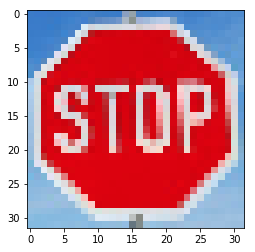

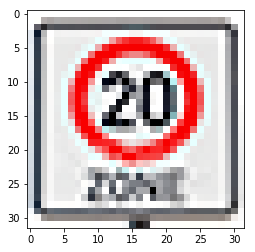

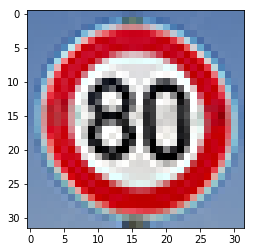

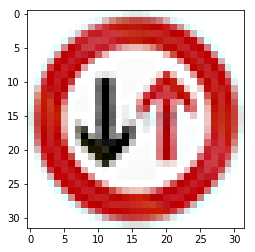

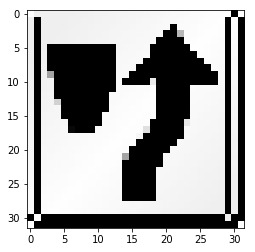

Tensor("labels:0", dtype=int64)


In [9]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
# print("Accuracy: ",accuracy.eval(session=sess, feed_dict={features: X_test, labels: y_test}))
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import csv



test_images = ['stop.png','20.png','80.png', 'priority.png', 'keepright.png']
new_test = []
print(len(test_images))
for img in test_images:
    readImage = mpimg.imread(img)
    readImage = readImage[:,:,:3]
#     image = cv2.cvtColor(pre_process(readImage), cv2.COLOR_BGRA2BGR)
    image = pre_process(readImage)
    plt.figure()
    plt.imshow(image)
    new_test.append(image)
    plt.show()
    
    

print(labels)

        
    

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:** The images are fairly blurry, but given that their dimensions are 32x32, we cannot expect much detail from them. The model is not nearly as accurate with the new images, as it is with its original training set, but it at least gets one of the signs correct, it also has a good second guess for the 80 km/h sign, and the signs where it is wrong generally have similar colors to the predicted sign.

In [10]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    new_saver = tf.train.import_meta_graph("traffic-signs-model.meta")
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
#     print (new_saver)
    prediction = tf.nn.softmax(logits)
    predictions = sess.run(prediction, {features: new_test})
    values, index = sess.run(tf.nn.top_k(prediction, 5), feed_dict={features: new_test})
#     print(predictions)
    i = 0 
    for p in predictions:

#         plt.figure()
#         plt.imshow(new_test[index])
#         plt.show()
#         for l in index[i]:
#             print(label_names[str(l)])
        print("Prediction: ",label_names[str(index[i][4])])
        print("Correct: ", test_images[i])
        i += 1
#         print(label_names[str(np.argmax(p))])
    #for each prediction in predictions, sess.run(tf.nn.top_k(prediction, 1))
    

Prediction:  Stop
Correct:  stop.png
Prediction:  Yield
Correct:  20.png
Prediction:  Speed limit (100km/h)
Correct:  80.png
Prediction:  End of speed limit (80km/h)
Correct:  priority.png
Prediction:  Road work
Correct:  keepright.png


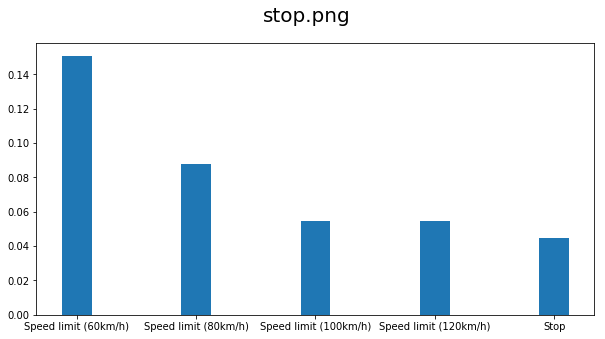

Prediction:  Stop
Correct:  stop.png


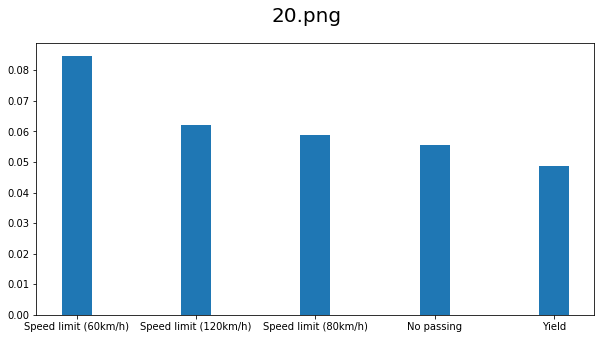

Prediction:  Yield
Correct:  20.png


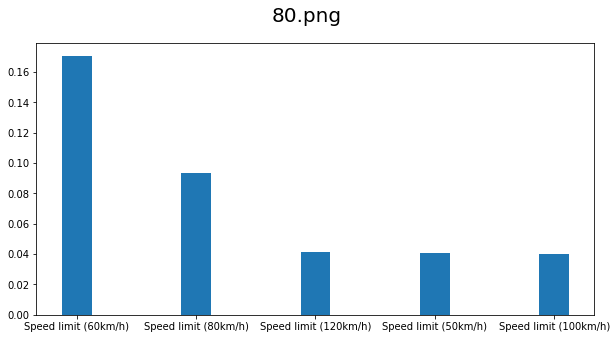

Prediction:  Speed limit (100km/h)
Correct:  80.png


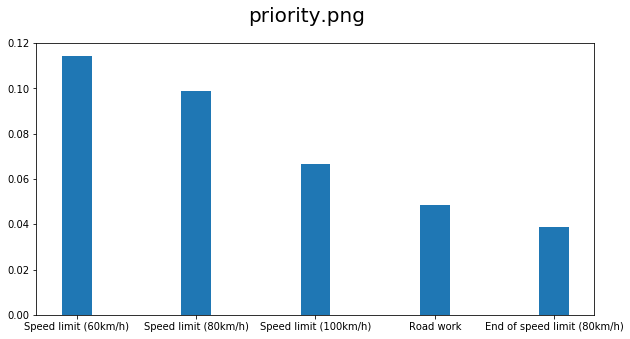

Prediction:  End of speed limit (80km/h)
Correct:  priority.png


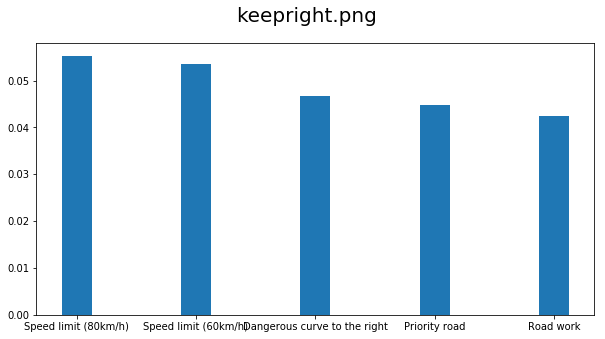

Prediction:  Road work
Correct:  keepright.png


In [11]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt


with tf.Session() as sess:
    sess.run(init)
    new_saver = tf.train.import_meta_graph("traffic-signs-model.meta")
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
#     print (new_saver)
    prediction = tf.nn.softmax(logits)
    predictions = sess.run(prediction, {features: new_test})
    values, index = sess.run(tf.nn.top_k(prediction, 5), feed_dict={features: new_test})
#     print(predictions)
    i = 0 
    for p in predictions:

#         plt.figure()
#         plt.imshow(new_test[index])
#         plt.show()
#         for l in index[i]:
#             print(label_names[str(l)])
       
        predicted_classes = []
        for l in index[i]:
            predicted_classes.append((label_names[str(l)]))
        fig, ax = plt.subplots()
        ax.get_xaxis().get_major_formatter().set_scientific(False)
        ax.set_xticklabels(predicted_classes)
        fig.set_size_inches(10,5)
        # fig.canvas.draw()
        plt.xticks(values[i], predicted_classes, rotation='vertical')
        # plt.hist(label_count,43,alpha=0.5)

        fig.suptitle(test_images[i], fontsize=20)
       
        plt.bar([0,1,2,3,4], values[i], align='center', width=0.25)
        plt.xticks([0,1,2,3,4], predicted_classes, rotation='horizontal')
        plt.show()
        print("Prediction: ",label_names[str(index[i][4])])
        print("Correct: ", test_images[i])
        i += 1

#         print(label_names[str(np.argmax(p))])
    #for each prediction in predictions, sess.run(tf.nn.top_k(prediction, 1))

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

The model was not really certain of any prediction. It was heavily biased towards things it was trained more intensely on, in particular the speed limit signs. The correct predictions don't appear anywhere near the top. We can see that none of the certainties go over 50%. In this sense, we can see the model is accurate, in that it is wrong.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.